# Avis uber

Ce projet vise à analyser les avis des utilisateurs d'Uber à travers une `analyse exploratoire` des données approfondie, suivie d'une phase de `prédiction` basée sur des modèles de `machine learning`.

## Librairies  

In [1]:
import os 
import re 
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import joblib 


# I- Présentation et analyse des données

*Source des données* : Les données utilisées dans ce projet sont intitulées `Uber Customer Reviews Dataset (2024)` et proviennent de la plateforme Kaggle. Elles sont mises à disposition sous forme d’un fichier au format CSV. 

*Structure des données*:  Le dataset est organisé en 10 colonnes, représentant les différentes caractéristiques des avis clients.

Voici une description des principales colonnes : 

 Nom de la colonne -> Description 
- userName -> Nom d'utilisateur anonyme de l'évaluateur.
- userImage -> URL de l'image de profil de l'évaluateur (si disponible).
- Contenu -> Texte de l'avis décrivant l'expérience de l'utilisateur.
- score -> Note numérique donnée par l'utilisateur (1-5).
- thumbsUpCount -> Nombre de likes reçus par l'avis.
- Version de l'application -> Version de l'application au moment de la création de l'avis (si disponible).
- at -> Horodatage indiquant le moment où l'avis a été posté.
- replyContent -> Réponse du développeur à l'avis (le cas échéant).
- repliedAt -> Horodatage indiquant le moment où le développeur a répondu (le cas échéant).
- appVersion -> Chaîne de caractères de la version de l'application associée à la critique (si disponible).



### 1- Les données

In [9]:
chemin_donnee = "./Données/uber_reviews.csv"

data =  pd.read_csv(chemin_donnee)

data.head()  

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


In [10]:
data.tail() 

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
11995,User_11995,NaN,Excellent!!!,5,0,4.553.10000,2024-11-24 21:59:16,NaN,NaN,4.553.10000
11996,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000
11997,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000
11998,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000
11999,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,2024-11-24 21:44:44,NaN,NaN,NaN


In [11]:
data.shape

(12000, 10)

Notre jeu de données contient 12 000 lignes et 10 colonnes.

In [12]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userName              12000 non-null  object 
 1   userImage             0 non-null      float64
 2   content               12000 non-null  object 
 3   score                 12000 non-null  int64  
 4   thumbsUpCount         12000 non-null  int64  
 5   reviewCreatedVersion  10260 non-null  object 
 6   at                    12000 non-null  object 
 7   replyContent          33 non-null     object 
 8   repliedAt             33 non-null     object 
 9   appVersion            10260 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB


- Les colonnes `userName`, `content`, ` score`, `at` et `thumbsUpCount` sont entièrement remplie, ce qui est un bon signe. 
- La colonne `userImage` ne contient aucune donnée utile donc Elle est candidate à être supprimée. 
- Les  colonnes `reviewCreatedVersion` et `appVersion`  indiquant respectivement  la version de l’application à laquelle l’avis se rapporte et la version de l’application utilisée par les utilisateurs contiennent chacune 1740 valeurs manquantes. 
- Les colonnes `replyConten`et `repliedAt` présentent seulement 33 valeurs non null ce qui limite leur utilisation dans nos travaux. 

### 2- Traitement et nettoyage des données

- **Suppression des colonnes inutiles**

In [13]:
col_a_supp = ['userName', 'userImage', 'replyContent', 'repliedAt']
data = data.drop(columns= col_a_supp) 
data.head() 

,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,Good,5,0,4.556.10005,2024-12-18 17:17:19,4.556.10005
1,Nice,5,0,4.556.10005,2024-12-18 17:17:17,4.556.10005
2,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,4.532.10001
3,Good,4,0,4.556.10005,2024-12-18 17:08:27,4.556.10005
4,exllence,5,0,4.556.10005,2024-12-18 17:08:16,4.556.10005


In [14]:
data['content'].unique()

array(['Good', 'Nice', 'Very convenient', ..., 'Excellent!!!',
       'Worst experience after 10pm in Hyde cityno auto is taking ride',
       'Very bad experience with this app, booked a short ride for 50rs but unwanted and unnamed fair is added without information and also location problem is there. Worst application.'],
      shape=(8172,), dtype=object)

In [15]:
data['word_count'] = data['content'].apply(lambda x: len(x.split())) 

data.head() 

,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,word_count
0,Good,5,0,4.556.10005,2024-12-18 17:17:19,4.556.10005,1
1,Nice,5,0,4.556.10005,2024-12-18 17:17:17,4.556.10005,1
2,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,4.532.10001,2
3,Good,4,0,4.556.10005,2024-12-18 17:08:27,4.556.10005,1
4,exllence,5,0,4.556.10005,2024-12-18 17:08:16,4.556.10005,1


In [16]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               12000 non-null  object
 1   score                 12000 non-null  int64 
 2   thumbsUpCount         12000 non-null  int64 
 3   reviewCreatedVersion  10260 non-null  object
 4   at                    12000 non-null  object
 5   appVersion            10260 non-null  object
 6   word_count            12000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 656.4+ KB


In [17]:
data.isnull().sum() 

content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    1740
at                         0
appVersion              1740
word_count                 0
dtype: int64

- **Imputation des Valeurs Manquantes**

In [18]:
data['reviewCreatedVersion'].fillna(data['reviewCreatedVersion'].mode()[0], inplace=True) 

data['appVersion'].fillna(data['appVersion'].mode()[0], inplace=True)

C:\Users\AFOLABI\AppData\Local\Temp\ipykernel_26488\1787676757.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['reviewCreatedVersion'].fillna(data['reviewCreatedVersion'].mode()[0], inplace=True)
C:\Users\AFOLABI\AppData\Local\Temp\ipykernel_26488\1787676757.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

L'imputation des valeurs manquantes a été effectuée sur les colonnes concernées afin d'éviter d'introduire des biais ou de compromettre l'intégrité des données.

Nous disposons désormais de données sans valeurs manquantes, ce qui permet de poursuivre les analyses 

In [19]:
data.isnull().sum() 

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
word_count              0
dtype: int64

In [20]:
data.describe() 

,score,thumbsUpCount,word_count
count,12000.000000,12000.000000,12000.000000
mean,3.925417,0.517000,11.977333
std,1.658940,6.298268,19.216809
min,1.000000,0.000000,1.000000
25%,3.000000,0.000000,2.000000
50%,5.000000,0.000000,3.000000
75%,5.000000,0.000000,12.000000
max,5.000000,239.000000,114.000000


 **commentaire**

 - Nombre total d'observations = 12000 dans chacune des colonnes 
 - `score` présente une note moyenne de 3.93, indiquant que la majorité des scores se situent autour de 4 , La Médiane (50%) de 5.00, ce qui signifie que la moitié des scores sont égaux ou inférieurs à 5 et un écart-type de 1.66, ce qui montre une certaine variation autour de la moyenne.

 - `thumbsUpCount` présente une moyenne de 0.52, montrant que, en moyenne, les avis reçoivent peu de "thumbs up" et un Écart-type de 6.30, suggérant que certaines valeurs de "thumbs up" s'écartent considérablement de la moyenne.

 - `word_count` présente une 11.98, indiquant que les avis contiennent en moyenne 12 mots, une Médiane : 6 mots, ce qui montre que la majorité des avis sont assez courts et un Écart-type de 19.22, suggérant une grande variabilité dans la longueur des avis.



# II- Visualisation des données

1. Repartition des notes des avis 

C:\Users\AFOLABI\AppData\Local\Temp\ipykernel_26488\451724439.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= data, x= 'score', palette='viridis')


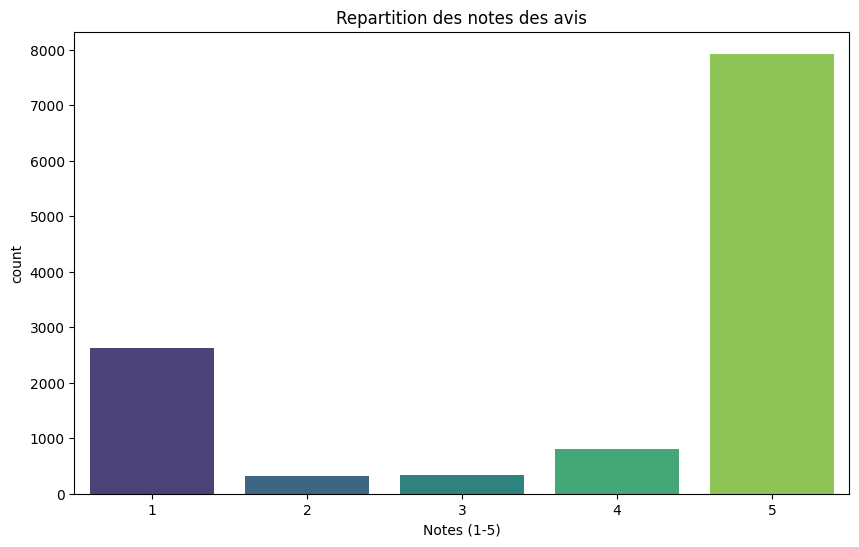

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data= data, x= 'score', palette='viridis')
plt.title('Repartition des notes des avis')
plt.xlabel('Notes (1-5)')
#plt.savefig('graph1.png') 
plt.show()

Le graphique ci dessus nous indique que La note 5 domine largement, ce qui indique une majorité d'avis très positifs et La note 1 est la deuxième catégorie la plus fréquente, soulignant une polarisation entre avis très positifs et très négatifs.

Les notes intermédiaires (2, 3, 4) sont peu fréquentes, ce qui pourrait suggérer que les utilisateurs ont tendance à laisser des avis extrêmes.

2. Relations entre la note et le nombre de pouces levés 

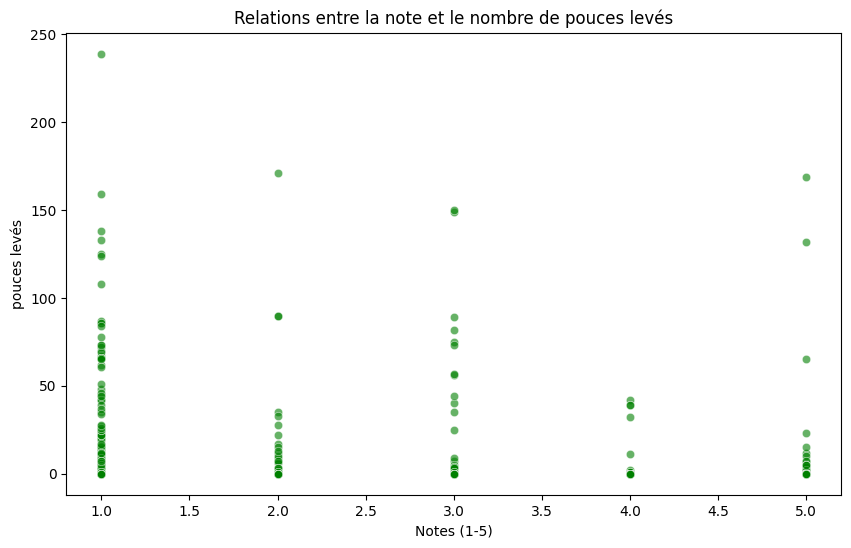

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data= data, x= 'score', y= 'thumbsUpCount', alpha=0.6, color='green')
plt.title('Relations entre la note et le nombre de pouces levés')
plt.xlabel('Notes (1-5)')
plt.ylabel('pouces levés')
#plt.savefig('graph_sns.png')
plt.show()

Le graphique ci dessus nous montre qu'il n'y a pas de corrélation claire entre la note donnée et le nombre de pouces levés. Certaines notes basses (1 et 2) ont des pouces levés élevés, ce qui pourrait être dû à des critiques constructives ou pertinentes. Les avis avec des notes élevées (4 et 5) semblent recevoir moins de pouces levés.

3. Longueur de l'avis  par rapport à la note 

C:\Users\AFOLABI\AppData\Local\Temp\ipykernel_26488\1345473303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= data, x= 'score', y='word_count', palette='viridis')


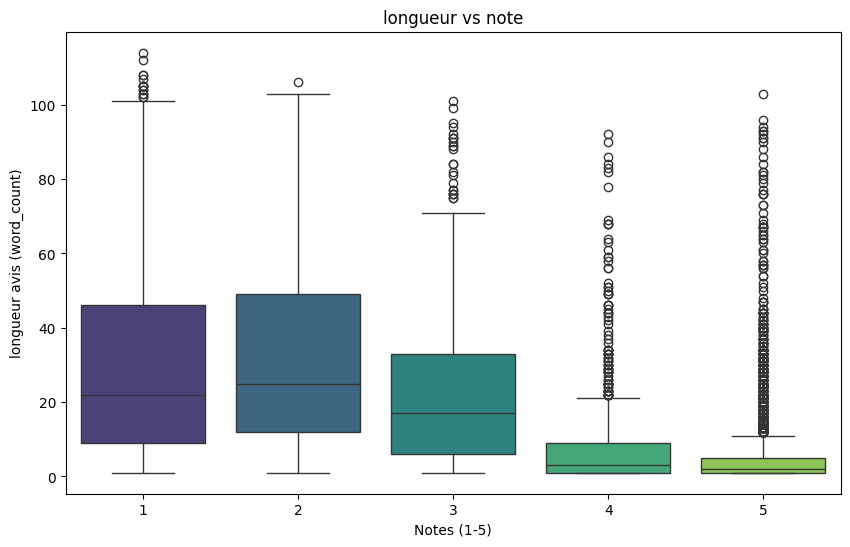

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data= data, x= 'score', y='word_count', palette='viridis')
plt.title('longueur vs note')
plt.xlabel('Notes (1-5)')
plt.ylabel('longueur avis (word_count)')
#plt.savefig('graph_box.png')
plt.show()

Le graphique ci dessus nous montre que Les avis ayant une note de 1 sont souvent plus longs que ceux avec une note de 5, comme le montrent les médianes respectives et  Les notes élevées (4 et 5) sont associées à des avis généralement plus courts.

Cela pourrait indiquer que les utilisateurs insatisfaits (note basse) expriment plus en détail leurs frustrations, alors que ceux qui sont satisfaits (note élevée) écrivent moins.

4. Evolution de la note dans le temps 

In [1]:
#data['at']= pd.to_datetime(data['at'])

#data['month'] = data['at'].dt.to_period('M') 
#monthly_scores= data.groupby('month')['score'].mean() 

#plt.figure(figsize=(10, 6))
#monthly_scores.plot(kind='line', color='green', linewidth=2)
#plt.title('Evolution de la note dans le temps')
#plt.xlabel('date (Monthly)')
#plt.ylabel('Note moyenne')
#plt.grid(True)
#plt.xticks(rotation =45)
#plt.show()


5. Lien entre reviewCreatedVersion et la note (Score)

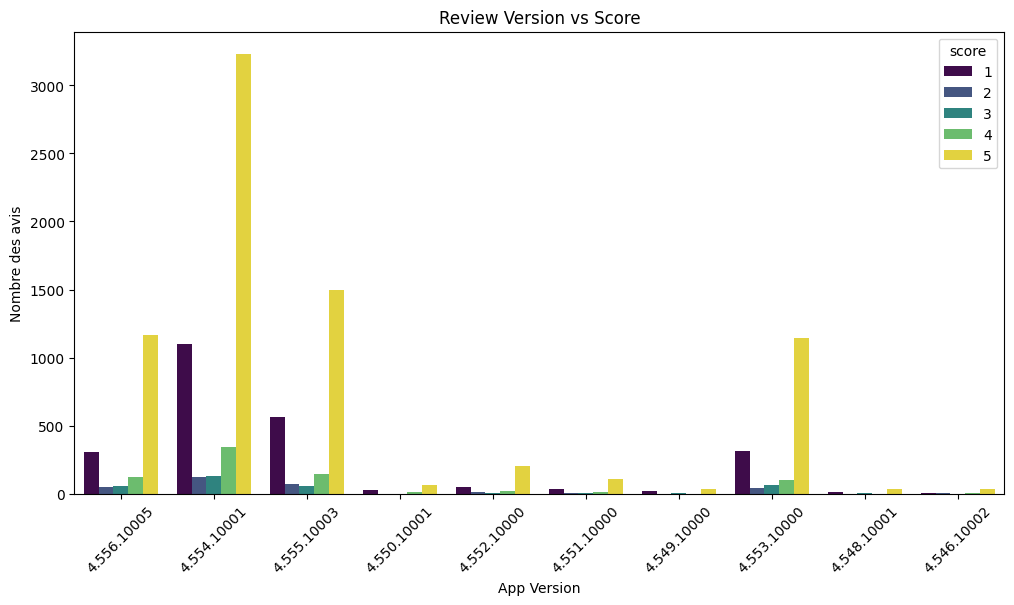

In [24]:
top_versions = data['reviewCreatedVersion'].value_counts().head(10).index


data_top_versions = data[data['reviewCreatedVersion'].isin(top_versions)]


plt.figure(figsize=(12, 6))
sns.countplot(data=data_top_versions, x='reviewCreatedVersion', hue='score', palette='viridis')
plt.title('Review Version vs Score')
plt.xlabel('App Version')
plt.ylabel('Nombre des avis')
plt.xticks(rotation=45)
plt.show()

# plt.savefig('graph_appVersion.png')

- Certaines versions de l'application (par exemple, 4.553.10001, 4.554.1001) ont reçu une majorité écrasante d'avis avec la note maximale (5).
Cela peut indiquer que les performances ou les fonctionnalités spécifiques à ces versions ont satisfait les utilisateurs.
- Quelques versions (par exemple, 4.56.10005) présentent une distribution plus équilibrée, incluant des notes faibles, ce qui pourrait pointer vers des problèmes ou des régressions introduites dans ces mises à jour.

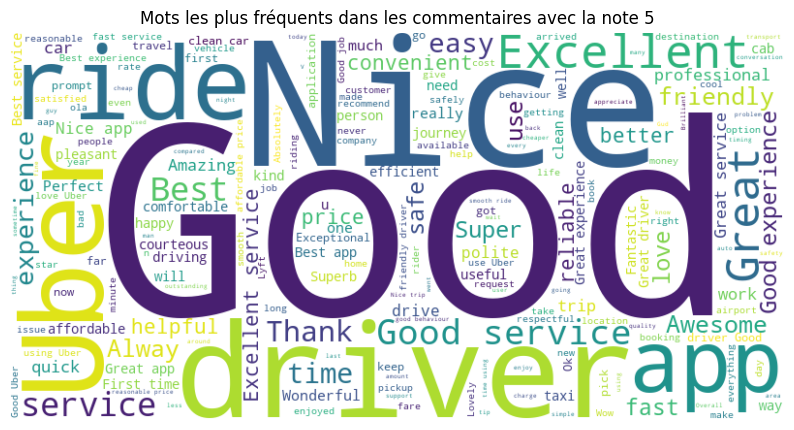

In [25]:
positive_reviews = data[data['score'] == 5]['content']


positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Mots les plus fréquents dans les commentaires avec la note 5')
plt.show()

- Les termes les plus fréquents incluent "Good", "Nice", "Excellent", "Ride", "Service", "Driver", "Uber", reflétant des expériences positives liées à la convivialité du service et des chauffeurs.
- Les adjectifs comme "friendly", "helpful", "fast", "affordable" suggèrent des aspects spécifiques que les utilisateurs apprécient.

6. appVersion vs Distribution de note

C:\Users\AFOLABI\AppData\Local\Temp\ipykernel_26488\283639794.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_top_app_versions, x='appVersion', y='score', palette='viridis')


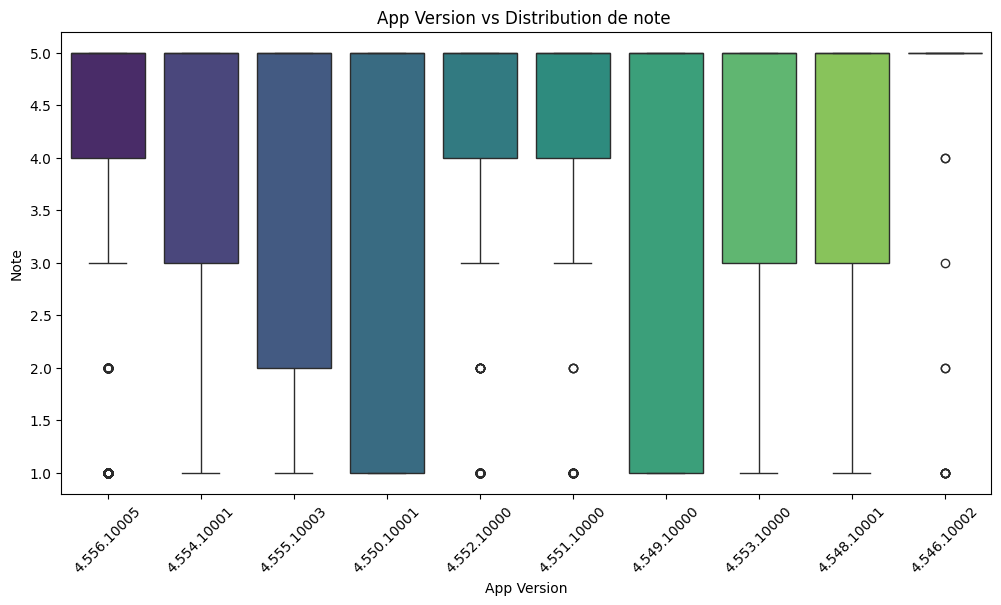

In [26]:
top_app_versions = data['appVersion'].value_counts().head(10).index


data_top_app_versions = data[data['appVersion'].isin(top_app_versions)]


plt.figure(figsize=(12, 6))
sns.boxplot(data=data_top_app_versions, x='appVersion', y='score', palette='viridis')
plt.title('App Version vs Distribution de note ')
plt.xlabel('App Version')
plt.ylabel('Note')
plt.xticks(rotation=45)
plt.show()

# plt.savefig('graph_appVersion_note.png') 

- Les versions les plus récentes (comme 4.55.10003) ont des médianes de note proches de 5, indiquant une satisfaction élevée.
- Cependant, les versions plus anciennes (comme 4.49.10000) montrent une plus grande variabilité, avec plusieurs avis attribuant des notes basses, ce qui pourrait refléter des problèmes résolus dans les versions ultérieures.

# III- Machine Learning 

Nous allons procéder à l'apprentissage automatique de nos données

#### 1- Data Preprocessing 

In [36]:
# convertir les notes(score) en étiquettes de sentiment
def get_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

data['sentiment'] = data['score'].apply(get_sentiment)


# Nettoyer la colonne de contenu (supprimer les caractères spéciaux, les mots d'arrêt, etc.)
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if len(word) > 1])  # Remove single-letter words
    return text

data['clean_content'] = data['content'].apply(clean_text)

# Supprimer les lignes dont le contenu ou le sentiment est manquant
data.dropna(subset=['clean_content', 'sentiment'], inplace=True)

In [37]:
# Split data into training and testing sets
X = data['clean_content']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2. Vectorisation avec TF-IDF

In [38]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### 3. Entrainement et évaluation du modèle

In [39]:
lr_model = LogisticRegression(max_iter=1000)


lr_model.fit(X_train_tfidf, y_train)


lr_pred = lr_model.predict(X_test_tfidf)


print("Logistic Regression Evaluation:")
print(classification_report(y_test, lr_pred))
print("Accuracy:", accuracy_score(y_test, lr_pred))

Logistic Regression Evaluation:
              precision    recall  f1-score   support

    Negative       0.83      0.87      0.85       554
     Neutral       0.00      0.00      0.00        80
    Positive       0.94      0.97      0.96      1766

    accuracy                           0.91      2400
   macro avg       0.59      0.61      0.60      2400
weighted avg       0.88      0.91      0.90      2400

Accuracy: 0.9141666666666667


c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


rf_model.fit(X_train_tfidf, y_train)


rf_pred = rf_model.predict(X_test_tfidf)


print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_pred))
print("Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82       554
     Neutral       0.00      0.00      0.00        80
    Positive       0.93      0.96      0.95      1766

    accuracy                           0.90      2400
   macro avg       0.58      0.60      0.59      2400
weighted avg       0.87      0.90      0.89      2400

Accuracy: 0.9025


c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
nb_model = MultinomialNB()


nb_model.fit(X_train_tfidf, y_train)


nb_pred = nb_model.predict(X_test_tfidf)


print("Naive Bayes Classifier Evaluation:")
print(classification_report(y_test, nb_pred))
print("Accuracy:", accuracy_score(y_test, nb_pred))

Naive Bayes Classifier Evaluation:
              precision    recall  f1-score   support

    Negative       0.81      0.88      0.84       554
     Neutral       0.00      0.00      0.00        80
    Positive       0.95      0.96      0.96      1766

    accuracy                           0.91      2400
   macro avg       0.59      0.61      0.60      2400
weighted avg       0.88      0.91      0.90      2400

Accuracy: 0.9125


c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
svm_model = SVC(kernel='linear', random_state=42)


svm_model.fit(X_train_tfidf, y_train)


svm_pred = svm_model.predict(X_test_tfidf)

print("SVM Evaluation:")
print(classification_report(y_test, svm_pred))
print("Accuracy:", accuracy_score(y_test, svm_pred))

SVM Evaluation:
              precision    recall  f1-score   support

    Negative       0.83      0.89      0.86       554
     Neutral       0.00      0.00      0.00        80
    Positive       0.95      0.97      0.96      1766

    accuracy                           0.92      2400
   macro avg       0.59      0.62      0.60      2400
weighted avg       0.89      0.92      0.90      2400

Accuracy: 0.9179166666666667


c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AFOLABI\Uber Avis\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
#import pandas as pd

# Résultats des accuracies et F1-scores pour chaque modèle
model_performance = {
    "Model": ["SVM", "Naive Bayes", "Random Forest", "Logistic Regression"],
    "Accuracy": [0.9183, 0.9117, 0.9042, 0.9142],  # Accuracy de chaque modèle
    "F1-Score (Weighted Avg)": [0.90, 0.90, 0.89, 0.90]  # Weighted avg F1-Score de chaque modèle
}

# Créer un DataFrame
performance_df = pd.DataFrame(model_performance)

# Afficher le DataFrame
performance_df

# sauvegarde en csv 
performance_df.to_csv('performance_df.csv', index=False)

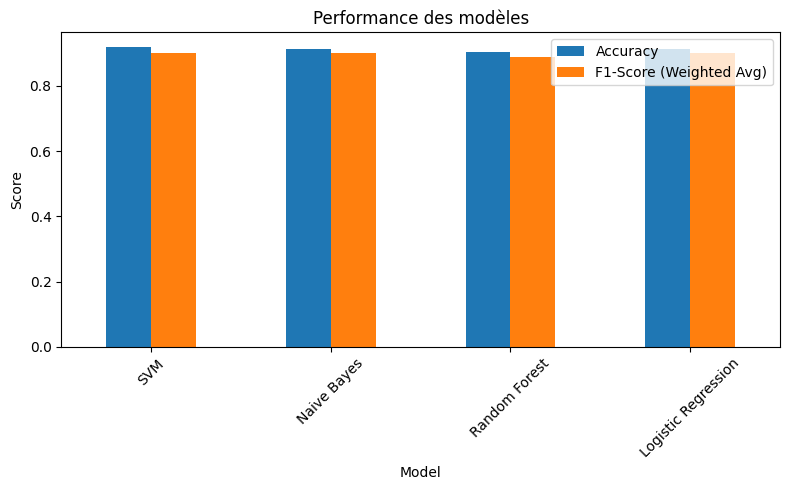

In [44]:
#import matplotlib.pyplot as plt

# Plot des résultats
fig, ax = plt.subplots(figsize=(8, 5))
performance_df.set_index("Model").plot(kind="bar", ax=ax)
plt.title("Performance des modèles")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("model_performance_comparison.png", dpi=300)
plt.show()


- Performances similaires:
        Les quatre modèles affichent des scores très proches, à la fois en termes d'Accuracy et de F1-Score pondéré.
        Cela suggère que tous les modèles sont efficaces et cohérents dans leurs prédictions sur ce jeu de données.
- Différence minimale entre Accuracy et F1-Score:
        La faible différence entre les deux métriques indique que les classes sont probablement équilibrées ou que les modèles gèrent bien les déséquilibres éventuels.
- Scores élevés (~0.9) :
        Les scores autour de 0.9 indiquent une très bonne performance globale, ce qui suggère que les modèles capturent bien les patterns du jeu de données.

## Conclusion 

- *Analyse Exploratoire des Données* :

Une analyse détaillée des versions de l'application a permis d’identifier les versions ayant un impact significatif sur les notes utilisateurs.
Un nuage de mots a révélé les termes les plus fréquents associés à la satisfaction des utilisateurs (note 5), mettant en lumière des aspects positifs comme la "fiabilité", la "qualité du service", et l'"expérience utilisateur".
La distribution des notes a confirmé une tendance générale vers des avis positifs, tout en soulignant des exceptions notables.

- *Modélisation et Performance* :

Plusieurs modèles (SVM, Naive Bayes, Random Forest, Logistic Regression) ont été testés pour la prédiction de la satisfaction utilisateur.
Tous les modèles ont montré des performances élevées, avec des scores d'Accuracy et de F1-Score proches de 90%, témoignant de la qualité des données et de leur préparation.

- *Insights Clés* :

Certaines versions de l'application nécessitent une attention particulière pour améliorer l'expérience utilisateur.
Les avis positifs sont principalement associés à des thèmes comme la "facilité d'utilisation", la "courtoisie des conducteurs", et le "rapport qualité-prix".
Les modèles testés sont robustes et pourraient être utilisés en production pour anticiper la satisfaction des utilisateurs et prioriser les retours.
Perspectives :

Intégration des modèles dans un tableau de bord opérationnel pour une surveillance continue des avis utilisateurs.
Amélioration des modèles en incorporant des données supplémentaires, comme les données de localisation ou le temps d'attente.
Mise en place de solutions ciblées pour améliorer les versions d'application identifiées comme problématiques.